In [26]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchsummary import summary
import glob
import os
import pandas as pd
from PIL import Image
from torchvision.models import efficientnet_b0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [27]:
collab = False
BATCH_SIZE = 16
NUM_WORKERS = 4
EPOCHS = 1000


if collab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    ROOT_DIR = '/content/drive/MyDrive/ai_data/rov/data/cube'
    EPOCHS = 10000
    BATCH_SIZE = 32
else:
    ROOT_DIR = './data'

torch.Size([23, 3, 256, 256])


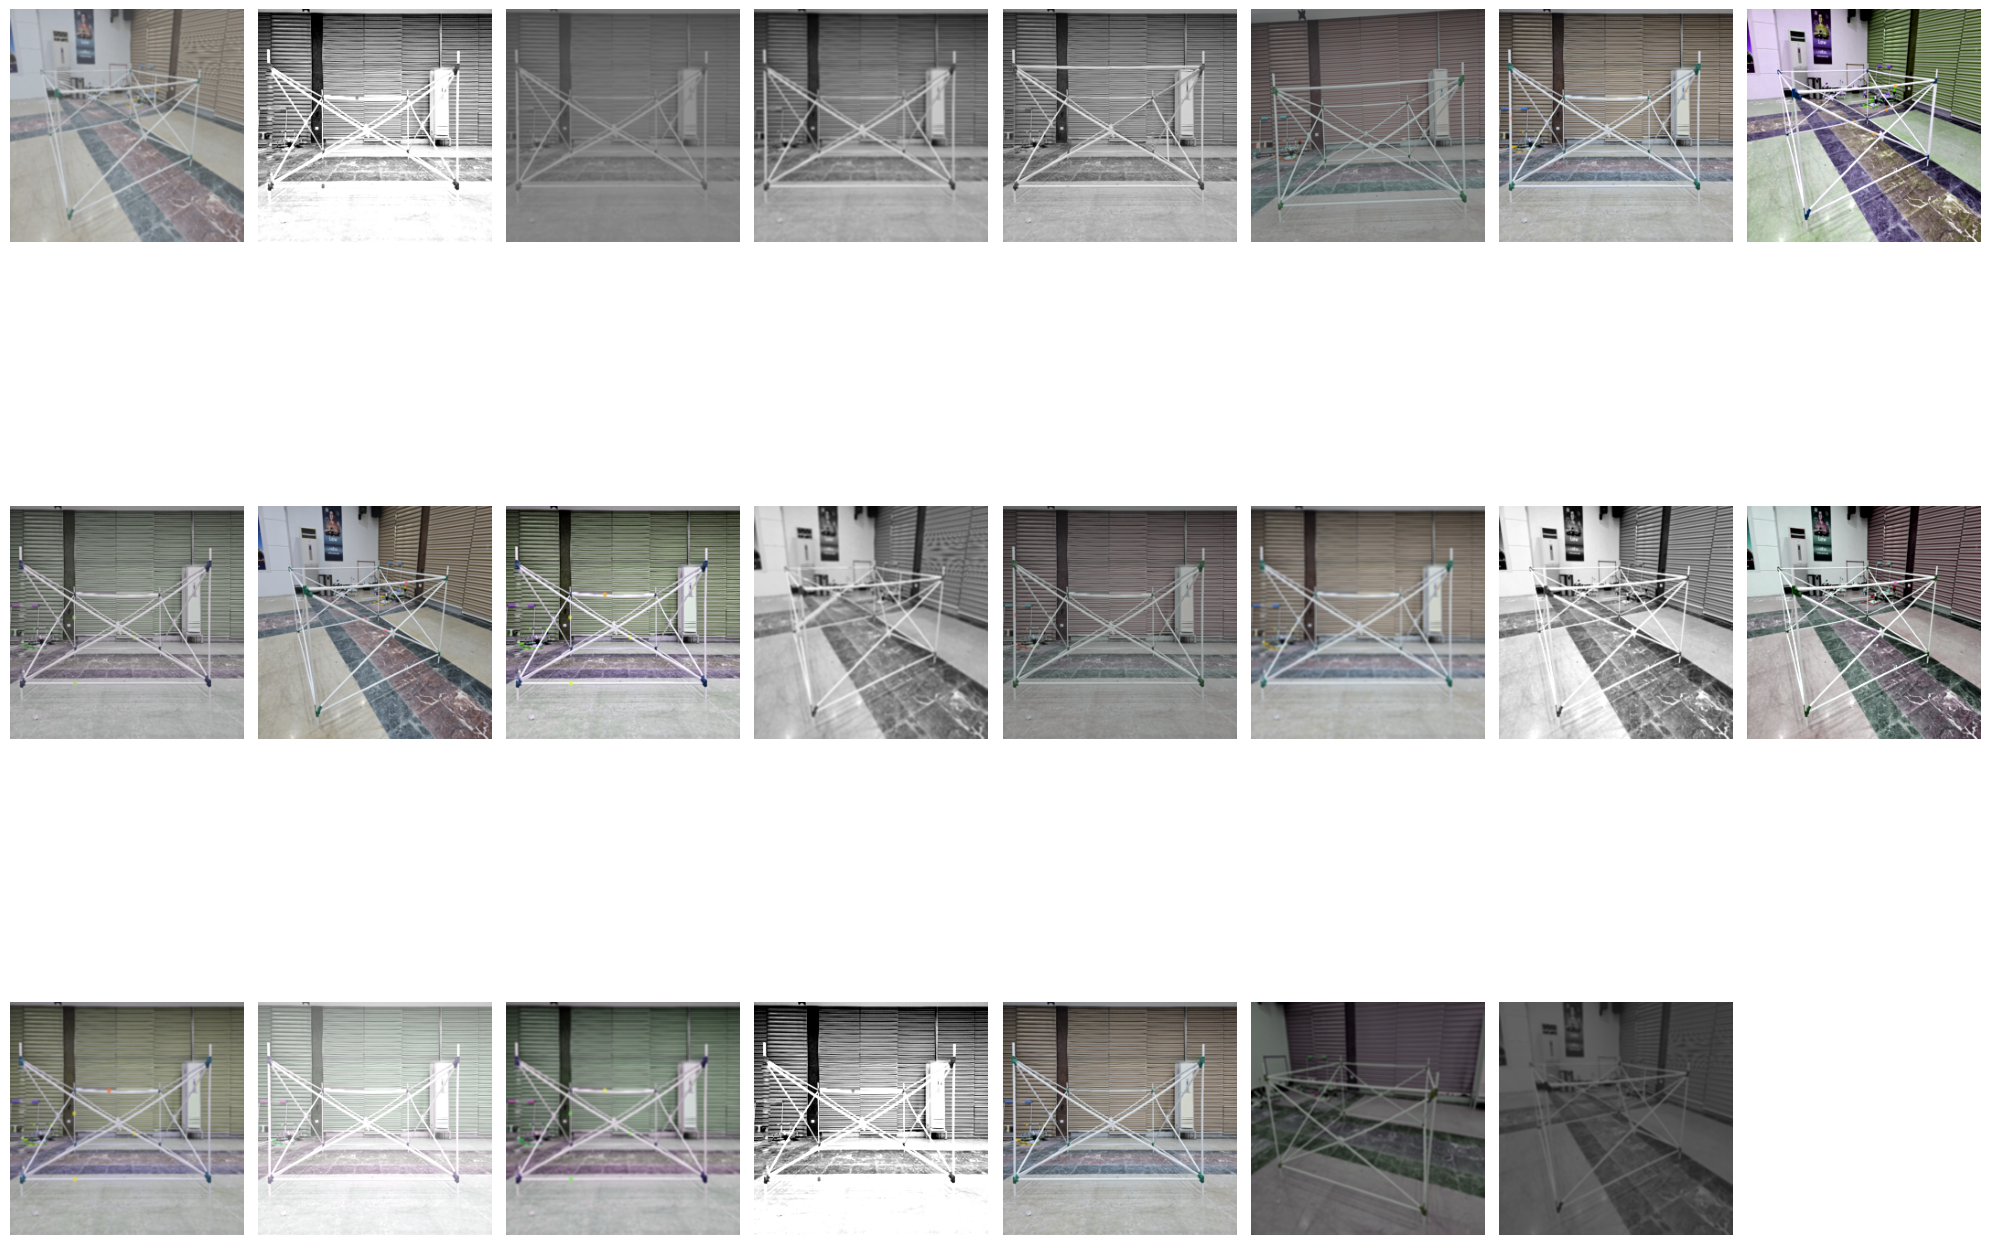

In [44]:
class CubeDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.transform = transform

        models_dir = os.path.join(ROOT_DIR, "models")
        real_dir = os.path.join(ROOT_DIR, "real")
        annots_dir = os.path.join(ROOT_DIR, "annots")

        # Load all annotation dataframes
        models_missing_df = pd.read_csv(os.path.join(annots_dir, "models_missing.csv"), dtype=str).set_index("dir_name")
        models_oxide_df = pd.read_csv(os.path.join(annots_dir, "models_oxide.csv"), dtype=str).set_index("dir_name")
        models_odd_df = pd.read_csv(os.path.join(annots_dir, "models_odd_size.csv"), dtype=str).set_index("dir_name")

        real_missing_df = pd.read_csv(os.path.join(annots_dir, "real_missing.csv"), dtype=str).set_index("name")
        real_oxide_df = pd.read_csv(os.path.join(annots_dir, "real_oxide.csv"), dtype=str).set_index("name")
        real_odd_df = pd.read_csv(os.path.join(annots_dir, "real_odd_size.csv"), dtype=str).set_index("name")

        self.data = []
        self.missing_labels = []
        self.oxide_labels = []
        self.odd_size_labels = []
        self.source = []  # 0 for artificial, 1 for real

        # # Process artificial (models) data
        # for model_path in glob.glob(os.path.join(models_dir, "*")):
        #     dir_name = os.path.basename(model_path)
        #     if (dir_name not in models_missing_df.index or
        #         dir_name not in models_oxide_df.index or
        #         dir_name not in models_odd_df.index):
        #         continue

        #     imgs = []
        #     for ext in ("*.jpeg", "*.jpg", "*.png"):
        #         imgs.extend(glob.glob(os.path.join(model_path, ext)))
        #     if not imgs:
        #         continue

        #     missing_ann = models_missing_df.loc[dir_name]
        #     oxide_ann = models_oxide_df.loc[dir_name]
        #     odd_ann = models_odd_df.loc[dir_name]

        #     missing_face_labels = [[int(c) for c in missing_ann[face].strip()] for face in ["front", "left", "back", "right"]]
        #     oxide_face_labels = [[int(c) for c in oxide_ann[face].strip()] for face in ["front", "left", "back", "right"]]
        #     odd_face_labels = [[int(c) for c in odd_ann[face].strip()] for face in ["front", "left", "back", "right"]]

        #     for img_path in imgs:
        #         self.data.append(img_path)
        #         self.missing_labels.append(missing_face_labels)
        #         self.oxide_labels.append(oxide_face_labels)
        #         self.odd_size_labels.append(odd_face_labels)
        #         self.source.append(0)

        # Process real data
        for ext in ("*.jpeg", "*.jpg", "*.png"):
            for img_path in glob.glob(os.path.join(real_dir, ext)):
                name = os.path.basename(img_path)
                if (name not in real_missing_df.index or
                    name not in real_oxide_df.index or
                    name not in real_odd_df.index):
                    continue

                missing_ann = real_missing_df.loc[name]
                oxide_ann = real_oxide_df.loc[name]
                odd_ann = real_odd_df.loc[name]

                missing_face_labels = [[int(c) for c in missing_ann[face].strip()] for face in ["front", "left", "back", "right"]]
                oxide_face_labels = [[int(c) for c in oxide_ann[face].strip()] for face in ["front", "left", "back", "right"]]
                odd_face_labels = [[int(c) for c in odd_ann[face].strip()] for face in ["front", "left", "back", "right"]]

                self.data.append(img_path)
                self.missing_labels.append(missing_face_labels)
                self.oxide_labels.append(oxide_face_labels)
                self.odd_size_labels.append(odd_face_labels)
                self.source.append(1)

        assert len(self.data) == len(self.missing_labels) == len(self.oxide_labels) == len(self.odd_size_labels) == len(self.source), "Data/Labels/Source length mismatch"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        missing_tensor = torch.tensor(self.missing_labels[idx], dtype=torch.float32)
        oxide_tensor = torch.tensor(self.oxide_labels[idx], dtype=torch.float32)
        odd_size_tensor = torch.tensor(self.odd_size_labels[idx], dtype=torch.float32)
        return img, missing_tensor, oxide_tensor, odd_size_tensor

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.5, 0.3)], p=0.8),
    transforms.RandomGrayscale(p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3,3))], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CubeDataset(transform=train_transform)

source_counts = torch.bincount(torch.tensor(train_dataset.source, dtype=torch.long))
inv_counts = 1.0 / source_counts.float()
sample_weights = [inv_counts[s] for s in train_dataset.source]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True) # type: ignore

BATCH_SIZE = 32
NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# Visualization example (unchanged)
img, missing, oxided, odd = next(iter(train_loader))
print(img.shape)
plt.figure(figsize=(20, 20))
for i in range(len(img)):
    plt.subplot(4, 8, i + 1)
    img_show = img[i].permute(1, 2, 0)
    img_show = img_show * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img_show = torch.clamp(img_show, 0, 1)
    plt.imshow(img_show)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
class PipeNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = efficientnet_b0(weights='DEFAULT').features
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.backbone[-1].parameters():
            param.requires_grad = True
            
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Linear(1280, 320),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.missing_head = nn.Linear(320, 4*10)
        self.oxide_head = nn.Linear(320, 4*10)
        self.odd_head = nn.Linear(320, 4*10)

    def forward(self, x):
        x = self.pool(self.backbone(x)).flatten(1)
        x = self.head(x)
        return {
            "missing": self.missing_head(x).view(-1, 4, 10),
            "oxide": self.oxide_head(x).view(-1, 4, 10),
            "odd": self.odd_head(x).view(-1, 4, 10)
        }

model = PipeNetwork().to(device)
# model.load_state_dict(torch.load(f'{ROOT_DIR}/checkpoints/pipe_detector.pth'))
model.to(device)
# model(torch.randn(16, 3, 256, 256))
summary(model, torch.randn((16, 3, 256, 256)))
print()

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1280, 8, 8]          --
|    └─Conv2dNormActivation: 2-1              [-1, 32, 128, 128]        --
|    |    └─Conv2d: 3-1                       [-1, 32, 128, 128]        (864)
|    |    └─BatchNorm2d: 3-2                  [-1, 32, 128, 128]        (64)
|    |    └─SiLU: 3-3                         [-1, 32, 128, 128]        --
|    └─Sequential: 2-2                        [-1, 16, 128, 128]        --
|    |    └─MBConv: 3-4                       [-1, 16, 128, 128]        (1,448)
|    └─Sequential: 2-3                        [-1, 24, 64, 64]          --
|    |    └─MBConv: 3-5                       [-1, 24, 64, 64]          (6,004)
|    |    └─MBConv: 3-6                       [-1, 24, 64, 64]          (10,710)
|    └─Sequential: 2-4                        [-1, 40, 32, 32]          --
|    |    └─MBConv: 3-7                       [-1, 40, 32, 32]          (1

In [45]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(1, EPOCHS + 1):
    running_loss = 0.0
    for imgs, missing_label, oxide_label, odd_label in train_loader:
        imgs = imgs.to(device)
        missing_label = missing_label.to(device)
        oxide_label = oxide_label.to(device)
        odd_label = odd_label.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)  # [B,4,10]

        loss_missing = criterion(outputs['missing'], missing_label)
        loss_oxide = criterion(outputs['oxide'], oxide_label)
        loss_odd = criterion(outputs['odd'], odd_label)

        loss = loss_missing + loss_oxide + loss_odd
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch}/{EPOCHS} - Loss: {epoch_loss:.4f}")
    model.to(torch.device('cpu'))
    torch.save(model.state_dict(), f'{ROOT_DIR}/checkpoints/pipe_detector.pth')
    model.to(device)

Epoch 1/1000 - Loss: 0.1091
Epoch 2/1000 - Loss: 0.1425
Epoch 3/1000 - Loss: 0.1832
Epoch 4/1000 - Loss: 0.1167
Epoch 5/1000 - Loss: 0.1145
Epoch 6/1000 - Loss: 0.1130
Epoch 7/1000 - Loss: 0.1221
Epoch 8/1000 - Loss: 0.0855
Epoch 9/1000 - Loss: 0.1026
Epoch 10/1000 - Loss: 0.1129
Epoch 11/1000 - Loss: 0.1058
Epoch 12/1000 - Loss: 0.0826
Epoch 13/1000 - Loss: 0.1025
Epoch 14/1000 - Loss: 0.1456
Epoch 15/1000 - Loss: 0.0879
Epoch 16/1000 - Loss: 0.1694
Epoch 17/1000 - Loss: 0.1226
Epoch 18/1000 - Loss: 0.1193
Epoch 19/1000 - Loss: 0.1366
Epoch 20/1000 - Loss: 0.1280
Epoch 21/1000 - Loss: 0.0769
Epoch 22/1000 - Loss: 0.0647
Epoch 23/1000 - Loss: 0.0889
Epoch 24/1000 - Loss: 0.1068
Epoch 25/1000 - Loss: 0.1584
Epoch 26/1000 - Loss: 0.0736
Epoch 27/1000 - Loss: 0.1219
Epoch 28/1000 - Loss: 0.0908
Epoch 29/1000 - Loss: 0.1108
Epoch 30/1000 - Loss: 0.1215
Epoch 31/1000 - Loss: 0.1116
Epoch 32/1000 - Loss: 0.0907
Epoch 33/1000 - Loss: 0.0842
Epoch 34/1000 - Loss: 0.0919
Epoch 35/1000 - Loss: 0